# Traveling Salesman Problem:

In this project, I’ll be using a Genetic Algorithms to find a solution to the traveling salesman problem (TSP). The TSP is described as follows:
“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”

Given this, there are two important rules to keep in mind:
- Each city needs to be visited exactly one time
- We must return to the starting city, so our total distance needs to be calculated accordingly  

### Approach:  
Let’s start with a few definitions, rephrased in the context of the TSP:
- Gene: a city (represented as (x, y) coordinates)
- Individual (aka “chromosome”): a single route satisfying the conditions above
- Population: a collection of possible routes (i.e., collection of individuals)
- Parents: two routes that are combined to create a new route
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- Fitness: a function that tells us how good each route is (in our case, how short the distance is)
- Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Determine fitness
- 3. Select the mating pool
- 4. Breed
- 5. Mutate
- 6. Repeat  
Now, let’s see this in action!

## Creating the Genetic Algorithm:

First, I Create two classes: City and Fitness  
The City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) and a cleaner way to output the cities as coordinates with `__repr __`.

In [20]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [21]:
class City:
    def __init__(self, y, x):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better

In [22]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

### Creating our initial population

This is a Route generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [23]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Next, we create first "population" (list of routes)  
This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [24]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

### Determining Fitness

Ranking the individuals. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [25]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Selecting the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  

In [26]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [27]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Breeding

With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., Knapsack problem, or deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.  

However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent.

In [28]:
def breed(parent1, parent2):
    """
    This function should breed both parents (routes) and return a child route according to the ordered crossover algorithm  
    mentioned above. Please fill in the code to do so.
    """
    
    offspring = []
    
    parent1_list = list(parent1)
    parent2_list = list(parent2)
    
    splice1 = random.randint(0, len(parent1_list) - 1)
    splice2 = random.randint(splice1, len(parent1_list) - 1)
    
    parent1_element = parent1_list[splice1:splice2]
    parent2_element = parent2_list[splice1:splice2]
    
    parent2_start_elements = parent2_list[:splice1]
    parent2_end_elements = parent2_list[splice2:]
    
    for element in parent1_element:
        if element in parent2_start_elements:
            parent2_start_elements.remove(element)
        elif element in parent2_element:
            parent2_element.remove(element)
        elif element in parent2_end_elements:
            parent2_end_elements.remove(element)
    
    for element1 in parent2_start_elements:
        offspring.append(element1)
    for element2 in parent2_element:
        offspring.append(element2)
    for element3 in parent1_element:
        offspring.append(element3)
    for element4 in parent2_end_elements:
        offspring.append(element4)

    return offspring

Next, we’ll generalize this to create our offspring population. We use elitism to retain the best routes from the current population. Then, we use the breed function to fill out the rest of the next generation.

In [29]:
def breedPopulation(matingpool, eliteSize):
    """
    This function should return the offspring population from the current population using the breed function. It should 
    retain the eliteSize best routes from the current population. Then it should use the breed function to mate
    members of the population, to fill out the rest of the next generation. You may decide how to choose mates for individuals.
    """
    children_list = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children_list.append(matingpool[i])
    
    for i in range(0, length):
        child1 = breed(pool[i], pool[len(matingpool)-i-1])
        children_list.append(child1)
    return children_list

### Mutating
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. 

Since we need to abide by our rules, we can’t drop cities, and we can use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function. Each individual in the population is mutated, and thus called with mutate(), with probability mutationRate.

In [30]:
def mutate(individual):
    """
    This function should take in an individual (route) and return a mutated individual. Assume mutationRate is a probability
    between 0 and 1. Use the swap mutation described above to mutate the individual according to the mutationRate. Iterate 
    through each of the cities and swap it with another city according to the given probability.
    """
    point1 = random.randint(0,len(individual) - 1)
    point2 = random.randint(0,len(individual) - 1)
    
    individual_index_1 = individual[point1]
    individual_index_2 = individual[point2]
    
    replacement1 = individual[point1]
    replacement2 = individual[point2]
    
    individual[point1] = replacement2
    individual[point2] = replacement1
    
    return individual

Next, we can extend the mutate function to run through the new population.  

In [31]:
def mutatePopulation(population, mutationRate):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual using the mutationRate.
    """
    for i in population:
        if random.random() <= mutationRate:
            i = mutate(i)
    return population

### Repeating This Process
Pulling these pieces together, we create a function that produces a new generation. First, we rank the routes in the current generation using rankRoutes. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [32]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

### Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we do now is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance.

In [33]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    print("Initial Fitness: " + str(rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    print("Final Fitness: " + str(rankRoutes(pop)[0][1]))
    
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    return bestRoute

## Running the genetic algorithm

With everything in place, solving the TSP is as easy as two steps:  
First, we need a list of cities to travel between. For this demonstration, we’ll use the list of 20 biggest cities of United States:

## Create the City list
You need to put all the 20 cities as city objects in the cityList array. We will use the last column Coordinates to calculate the distance between all the cities. And for convenience we will multiply all the coordinates by 100. For example, for New York, it would be  
NewYork= City( int(40.71 * 100), int( -74.00 * 100))  
And then you can put cityList.append(NewYork)

In [37]:
# My city list Code:
Top_20_US_City_List = []
New_York = City(4071, -7400)
Los_Angeles = City(3405,-11824) 
Chicago = City(4187,-8763)
Houston = City(2976,-9537)
Philly = City(3995,-7517)
Phoenix = City(3344, -11207)
San_Antonio = City(2942, -9849)
San_Diego = City(3271, -11716)
Dallas = City(3277, -9680)
San_Jose = City(3733, -12189)
Austin = City(3027, -9774)
Indianapolis = City(3977, -8616)
Jacksonville = City(3033, -8166)
San_Francisco = City(3777, -12242)
Columbus = City(3996, -8300)
Charlotte = City(3523, -8084)
Fort_Worth = City(3276, -9733)
Detroit = City(4233, -8304)
El_Paso = City(3178, -10644)
Memphis = City(3515, -9005)

Top_20_US_City_List.append(New_York)
Top_20_US_City_List.append(LA)
Top_20_US_City_List.append(Chicago)
Top_20_US_City_List.append(Houston)
Top_20_US_City_List.append(Phoenix)
Top_20_US_City_List.append(Philly)
Top_20_US_City_List.append(San_Antonio)
Top_20_US_City_List.append(San_Diego)
Top_20_US_City_List.append(Dallas)
Top_20_US_City_List.append(San_Jose)
Top_20_US_City_List.append(Austin)
Top_20_US_City_List.append(Jacksonville)
Top_20_US_City_List.append(Fort_Worth)
Top_20_US_City_List.append(Columbus)
Top_20_US_City_List.append(Charlotte)
Top_20_US_City_List.append(San_Francisco)
Top_20_US_City_List.append(Indianapolis)
Top_20_US_City_List.append(Detroit)
Top_20_US_City_List.append(El_Paso)
Top_20_US_City_List.append(Memphis)

In [38]:
geneticAlgorithm(population = Top_20_US_City_List, popSize=100, eliteSize=5, mutationRate=0.01, generations=500)

Initial distance: 26347.40507348115
Final distance: 11851.854371375523
Initial Fitness: 8.437498206316049e-05
Final Fitness: 8.450404408012684e-05


[(-12242,3777),
 (-11207,3344),
 (-9733,3276),
 (-9680,3277),
 (-9537,2976),
 (-8166,3033),
 (-8084,3523),
 (-7517,3995),
 (-7400,4071),
 (-8304,4233),
 (-8300,3996),
 (-8616,3977),
 (-8763,4187),
 (-9005,3515),
 (-9774,3027),
 (-9849,2942),
 (-10644,3178),
 (-11716,3271),
 (-11824,3405),
 (-12189,3733)]

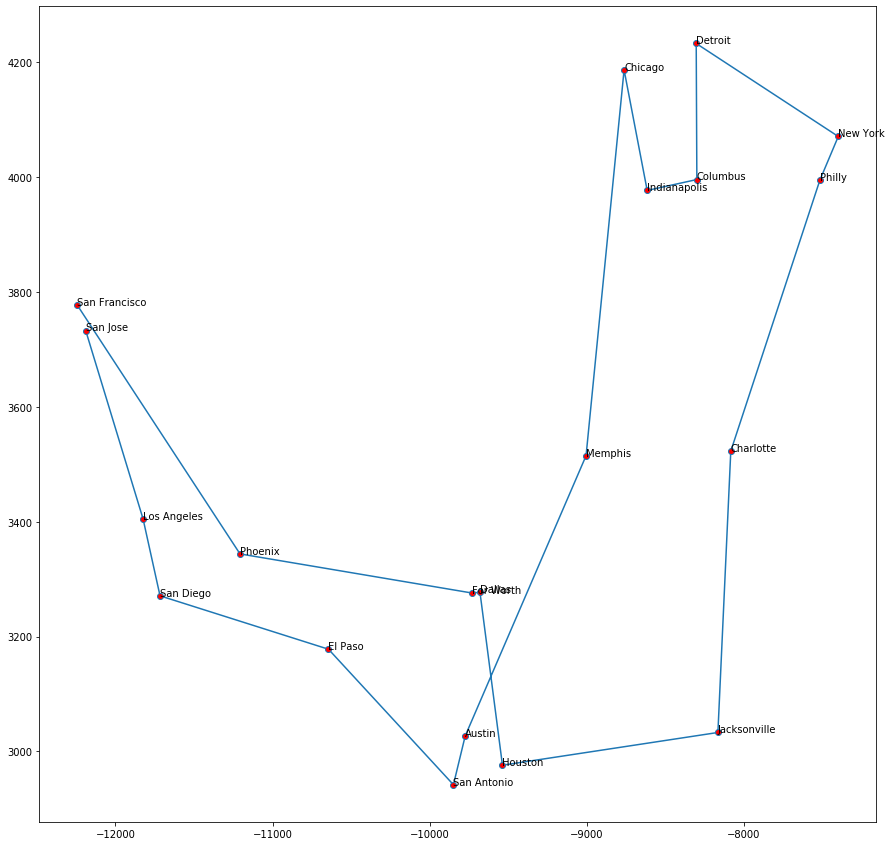

In [42]:
# Plotting the cities
route_list = [(-12242,3777),(-11207,3344),(-9733,3276),(-9680,3277),(-9537,2976),(-8166,3033),(-8084,3523),(-7517,3995),
              (-7400,4071),(-8304,4233),(-8300,3996),(-8616,3977),(-8763,4187),(-9005,3515),(-9774,3027),(-9849,2942),
              (-10644,3178),(-11716,3271),(-11824,3405),(-12189,3733)]

fig, ax1 = plt.subplots(ncols = 1, figsize = (15,15))
x = [route_list[0][0],route_list[1][0],route_list[2][0],route_list[3][0],route_list[4][0],route_list[5][0],route_list[6][0],
     route_list[7][0],route_list[8][0],route_list[9][0], route_list[10][0],route_list[11][0],route_list[12][0],
     route_list[13][0],route_list[14][0],route_list[15][0],route_list[16][0],route_list[17][0],route_list[18][0], 
     route_list[19][0]]
y = [route_list[0][1],route_list[1][1],route_list[2][1],route_list[3][1],route_list[4][1],route_list[5][1],route_list[6][1], 
     route_list[7][1],route_list[8][1],route_list[9][1],route_list[10][1],route_list[11][1],route_list[12][1],
     route_list[13][1],route_list[14][1],route_list[15][1],route_list[16][1],route_list[17][1],route_list[18][1], 
     route_list[19][1]]

n = ['San Francisco', 'Phoenix', 'For Worth', 'Dallas', 'Houston', 'Jacksonville', 'Charlotte', 'Philly', 'New York', 
     'Detroit', 'Columbus', 'Indianapolis', 'Chicago', 'Memphis', 'Austin', 'San Antonio', 'El Paso', 'San Diego', 
     'Los Angeles', 'San Jose']

ax1.plot(x, y, marker = "o", markerfacecolor = "r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

## The Optimal Path of Cities:

The optimal path my GA gave me was:

'San Francisco', 'Phoenix', 'For Worth', 'Dallas', 'Houston', 'Jacksonville', 'Charlotte', 'Philly', 'New York', 'Detroit', 'Columbus', 'Indianapolis', 'Chicago', 'Memphis', 'Austin', 'San Antonio', 'El Paso', 'San Diego', 'Los Angeles', and 'San Jose' in that order.

## Plot the Overall Progress:

It’s great to know our starting and ending distance and the proposed route, but we would be remiss not to see how our distance improved over time. With a simple tweak to our geneticAlgorithm function, we can store the shortest distance from each generation in a progress list and then plot the results.

In [43]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    
    fitness = []
    progress = []
    
    progress.append(1 / rankRoutes(pop)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    for x in progress:
        fitness.append(1/x)
    
    plt.plot(progress)
    plt.title('Distance vs Generation')
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    plt.plot(fitness)
    plt.title('Fitness vs Generation')
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    plt.show()

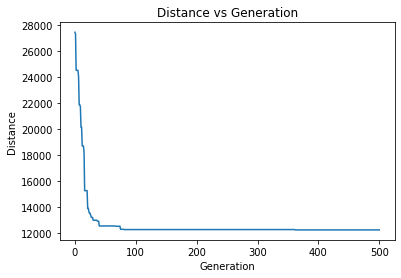

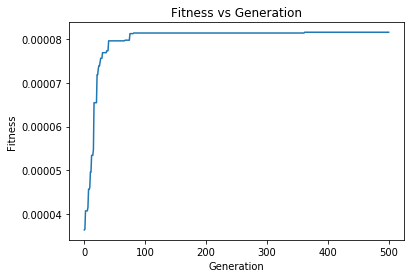

In [44]:
geneticAlgorithmPlot(population=Top_20_US_City_List, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)